In [37]:
%cd /home/tk/repos/erc/

/home/tk/repos/erc


In [38]:
from glob import glob
import json

def read_stats(path):
    with open(path, 'r') as stream:
        stats = json.load(stream)
        
    stats = {SPLIT: {key: val['mean'] for key, val in stats[SPLIT].items()} 
             for SPLIT in ['train', 'val', 'test']}
    return stats

def parse_path(path):
    path = path.split('/')[-2]
    NUM_UTTS = path.split('-')[0]
    BATCH_SIZE = path.split('-')[1]

    return {'NUM_UTTS': int(NUM_UTTS), 'BATCH_SIZE': int(BATCH_SIZE)}

single_seed = {}
# single_seed['SPEAKER'] = {DATASET: glob(f'./models/roberta.large/{DATASET}/single-seed/*/*upper*/results.json') 
#                             for DATASET in ['MELD', 'IEMOCAP', 'EmoryNLP', 'DailyDialog']}


single_seed['SPEAKER'] = {DATASET: glob(f'./models/roberta.large/{DATASET}/single-seed/*upper*/results.json') 
                            for DATASET in ['MELD', 'IEMOCAP', 'EmoryNLP', 'DailyDialog']}


single_seed['NOSPEAKER'] = {DATASET: glob(f'./models/roberta.large/{DATASET}/single-seed/*none*/results.json') 
                            for DATASET in ['MELD', 'IEMOCAP', 'EmoryNLP', 'DailyDialog']}



for SPEAKER_TYPE in ['SPEAKER', 'NOSPEAKER']:
    for DATASET in ['MELD', 'IEMOCAP', 'EmoryNLP', 'DailyDialog']:
        single_seed[SPEAKER_TYPE][DATASET] = \
            {parse_path(path)['NUM_UTTS']:read_stats(path) 
                for path in single_seed[SPEAKER_TYPE][DATASET]}
        single_seed[SPEAKER_TYPE][DATASET] = \
            {NUM_UTT: single_seed[SPEAKER_TYPE][DATASET][NUM_UTT] 
                for NUM_UTT in sorted(list(single_seed[SPEAKER_TYPE][DATASET].keys()))}
        single_seed[SPEAKER_TYPE][DATASET] = \
            [(NUM_UTT, val_cse)for NUM_UTT, val_cse in single_seed[SPEAKER_TYPE][DATASET].items()]

In [39]:
import matplotlib
from matplotlib import pyplot as plt

def get_stats_two_lists(SPLIT, one_list_stat, metric):
    num_utts = [foo[0] for foo in one_list_stat]
    stats = [foo[1][SPLIT][metric] for foo in one_list_stat]
    
    assert len(num_utts) == len(stats)
    
    return num_utts, stats

def plot_four_datasets(SPLIT, SPEAKER_TYPE, metric, seed_data):
    FOUR_DATASETS = ['MELD', 'IEMOCAP', 'EmoryNLP', 'DailyDialog']
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    fig.tight_layout(pad=3)
    fig.suptitle(f'{metric}, {SPEAKER_TYPE}, {SPLIT}')
    ax = ax.flatten()
    ax = {DATASET: ax[idx] for idx, DATASET in enumerate(FOUR_DATASETS)}
    
    for DATASET in FOUR_DATASETS:
        num_utts, stats = get_stats_two_lists(SPLIT, seed_data[SPEAKER_TYPE][DATASET], metric)

        foo = [foo for foo in zip(num_utts, stats)]
        foo.sort(key=lambda x:x[1])
    
        try:
            if metric == 'cross_entropy_loss':
                foo = foo[0]
            else:
                foo = foo[-1]

            foo = [round(foo, 3) for foo in foo]
        except:
            pass

#         print(foo)
        ax[DATASET].set_title(f"{DATASET}, {foo}")

        ax[DATASET].plot(num_utts, stats)        
        ax[DATASET].set_xlabel('number of utterances')
        ax[DATASET].set_ylabel(metric)
        ax[DATASET].set_xscale('log')
        ax[DATASET].set_xticks(num_utts)
        ax[DATASET].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


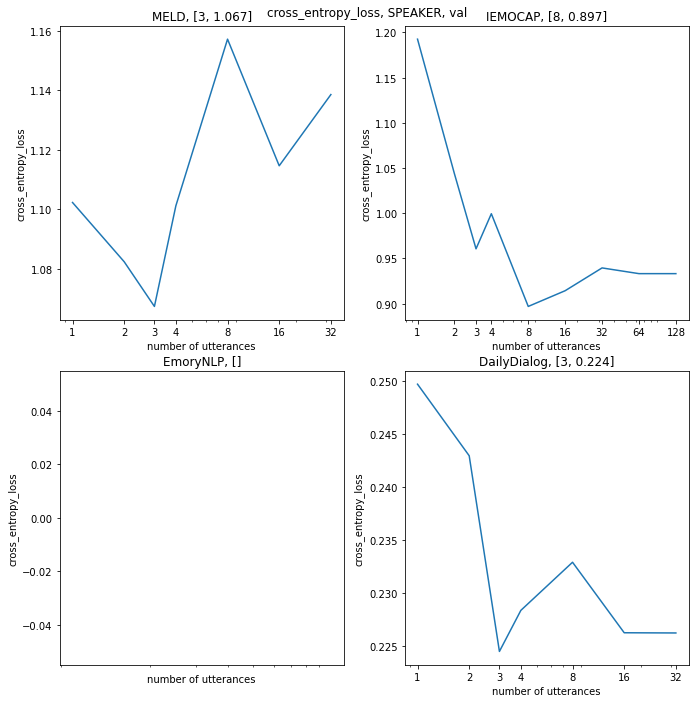

In [40]:
plot_four_datasets('val', 'SPEAKER', 'cross_entropy_loss', single_seed)

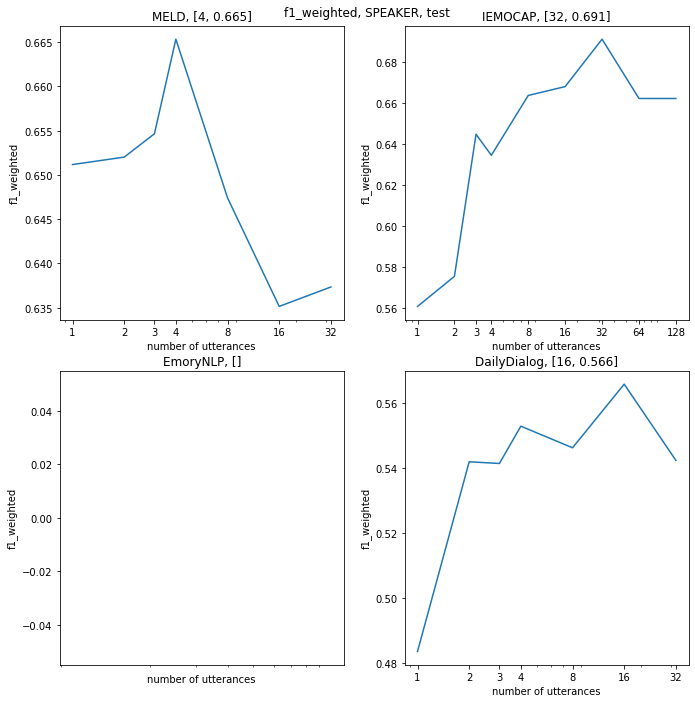

In [33]:
plot_four_datasets('test', 'SPEAKER', 'f1_weighted', single_seed)

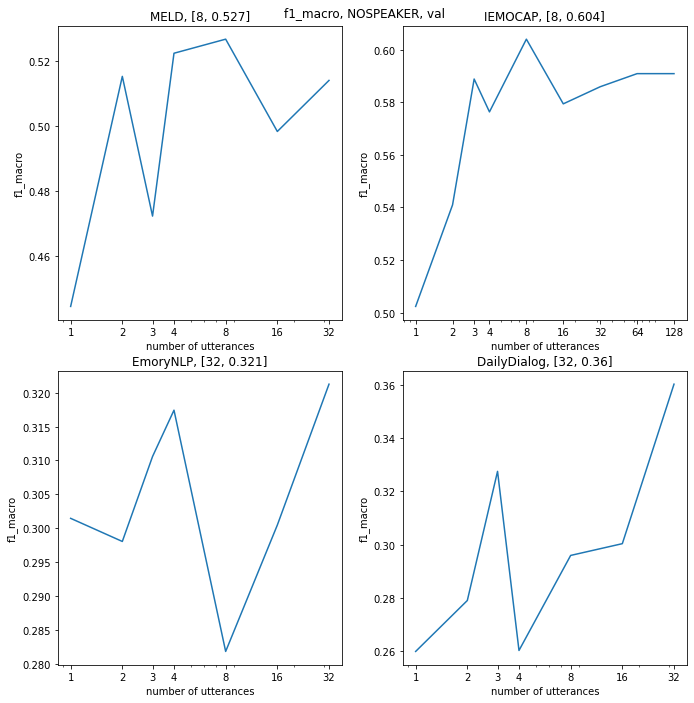

In [31]:
plot_four_datasets('val', 'NOSPEAKER', 'f1_macro', single_seed)

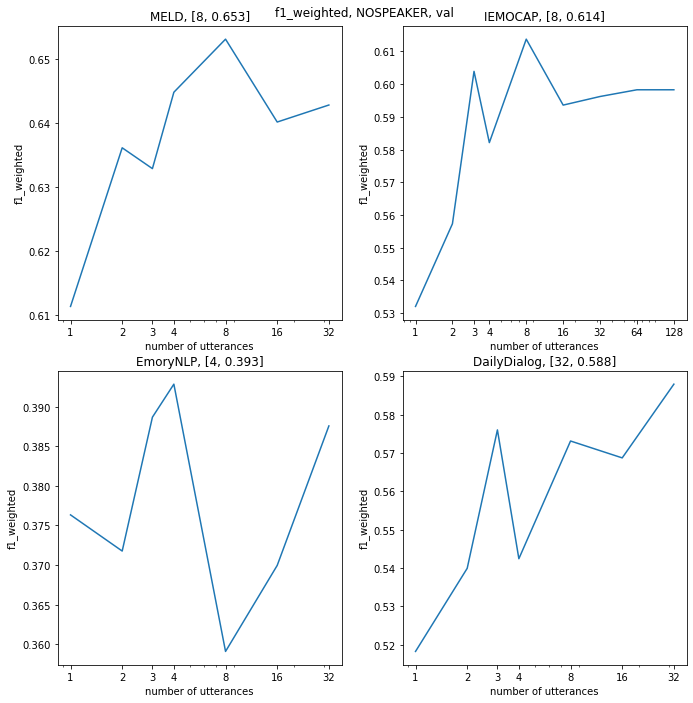

In [32]:
plot_four_datasets('val', 'NOSPEAKER', 'f1_weighted', single_seed)